In [16]:
 
from umap import UMAP
import matplotlib.pyplot as plt
import datasets
from sentence_transformers import SentenceTransformer
import numpy as np 
import matplotlib.pyplot as plt
model = SentenceTransformer("BAAI/bge-large-en")

import random
N= 1000
LLM_URL ="http://sdc:8896/v1"

In [2]:
ds = datasets.load_dataset("zeroshot/arxiv-biology")
ds = datasets.load_dataset("CCRss/arxiv_papers_cs")


README.md:   0%|          | 0.00/763 [00:00<?, ?B/s]

abs-bio1.csv:   0%|          | 0.00/1.69M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1277 [00:00<?, ? examples/s]

README.md:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

arxiv_cs_from2010to2024-01-01.parquet:   0%|          | 0.00/409M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/555563 [00:00<?, ? examples/s]

In [5]:
# a path between two high dim vectors
def generate_path(V1, V2, n):
    # Create n points from V1 to V2
    path = [V1 + (i / (n - 1)) * (V2 - V1) for i in range(n)]
    return np.array(path)


def closest_point_index_on_segment(x1, y1, x2, y2, points):
    import math
    
    def distance(xa, ya, xb, yb):
        return math.sqrt((xa - xb) ** 2 + (ya - yb) ** 2)

    min_distance = float('inf')
    closest_index = -1

    dx, dy = x2 - x1, y2 - y1
    d_squared = dx ** 2 + dy ** 2

    for i, (xn, yn) in enumerate(points):
        vx, vy = xn - x1, yn - y1
        t = (vx * dx + vy * dy) / d_squared if d_squared != 0 else -1
        
        if 0 <= t <= 1:
            xc, yc = x1 + t * dx, y1 + t * dy
            curr_distance = distance(xn, yn, xc, yc)
            
            if curr_distance < min_distance:
                min_distance = curr_distance
                closest_index = i

    return closest_index

In [6]:
abstracts = ds['train']['abstract']
random.shuffle(abstracts)

abstracts = abstracts[:N]
vectors = model.encode(abstracts)
transform = UMAP().fit(vectors)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


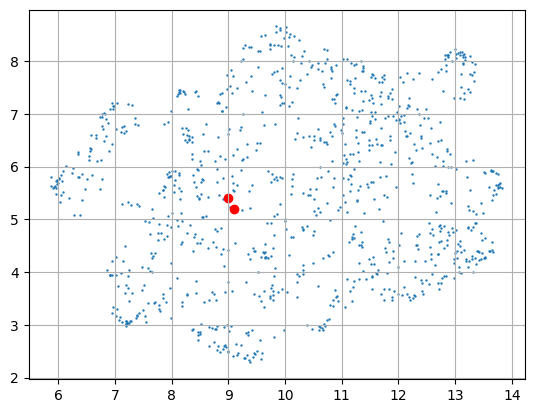

In [7]:
##### Select two points in a well represented area of the embedding diagram
plt.scatter(transform.embedding_[:,0], transform.embedding_[:,1], s=.5)
plt.grid()
p0 = np.array( [[9, 5.4]])
p1 = np.array([[9.1, 5.2]])
plt.scatter(p0[0][0], p0[0][1] ,c='r')
plt.scatter(p1[0][0], p1[0][1], c='r')

In [8]:
import faiss
idx = faiss.IndexFlatL2(2)
idx.add(transform.embedding_)

# find the abstract 
D,I = idx.search(p0,1)
ab_0 = abstracts[I[0][0]]

D,I = idx.search(p1,1)
ab_1 = abstracts[I[0][0]]

ab_0, "\n\n", ab_1

("we study whether a depth two neural network can learn another depth twonetwork using gradient descent. assuming a linear output node, we show that thequestion of whether gradient descent converges to the target function isequivalent to the following question in electrodynamics: given $k$ fixedprotons in $\\mathbb{r}^d,$ and $k$ electrons, each moving due to the attractiveforce from the protons and repulsive force from the remaining electrons,whether at equilibrium all the electrons will be matched up with the protons,up to a permutation. under the standard electrical force, this follows from theclassic earnshaw's theorem. in our setting, the force is determined by theactivation function and the input distribution. building on this equivalence,we prove the existence of an activation function such that gradient descentlearns at least one of the hidden nodes in the target network. iterating, weshow that gradient descent can be used to learn the entire network one node ata time.",
 '\n\n

In [17]:
from openai import OpenAI
from tqdm import tqdm 

alternate_prompt="Create a new abstract by synthesizing the concepts from two independent journal articles. Read and consider the ideas presented in Abstract 1, followed by Abstract 2. Identify any overlapping themes, relationships, or innovative connections between the two, no matter how subtle or unconventional. Develop a hypothesis that integrates these concepts and serves as the foundation for the new abstract. Then, craft a concise and descriptive abstract (250 words or less) that draws inspiration from one or both of the original abstracts. The new abstract can either merge the two or focus on select topics, presenting a fresh perspective or novel approach."


newpts = []
newabs = []
for _ in tqdm(range(20)):
    client= OpenAI(api_key="asdf", base_url=LLM_URL)
    prompt = f"""Here are two abstracts from two independent journal articles.  The goal is to draft a new
    abstract that will draw inspiration from both of these abstracts.  The new abstract may tie the two abstracts together or it may
    just incorporate one or more of the topics.  First consider the concepts of abstract 1, then the concepts of abstract 2. Then 
    identify any common factors, even if they are remote or novel.  Then formulate a hypothesis that 
    is the basis of the overall abstract, then write a complete new abstract.
    Be descriptive but no more than 250 words.  Do not include any commentary or explanation, just the new abstract.
    
    ### Abstract 1
    {ab_0}
    
    ### Abstract 2
    {ab_1}
    """
    messages = [{"role":"user", "content":prompt}]
    
    rc = client.chat.completions.create(model='asdf', messages= messages, temperature = 0.6)
    new_ab = rc.choices[0].message.content
    newabs.append(new_ab)
    new_vec = model.encode(new_ab)
    new_pt = transform.transform([new_vec])
    newpts.append(new_pt)
newpts = np.squeeze(np.array(newpts), axis=1)

100%|█████████████████████████████████████████████████████████████████████| 20/20 [03:21<00:00, 10.10s/it]


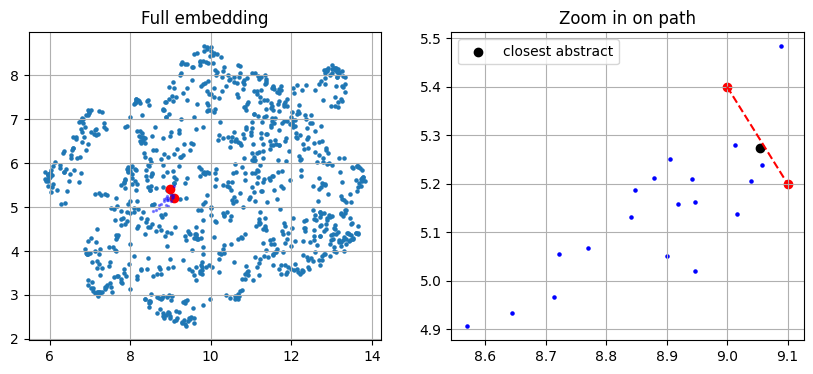

In [26]:
plt.figure(figsize=(10,4))
plt.subplot(121)
plt.scatter(transform.embedding_[:,0], transform.embedding_[:,1], s=5)
plt.grid()
plt.scatter(p0[0][0], p0[0][1] ,c='r')
plt.scatter(p1[0][0], p1[0][1], c='r')
plt.scatter(newpts[:,0], newpts[:,1], s=2,alpha=.4, c='b')
plt.title("Full embedding")
plt.subplot(122)
# zoom in on just the points
plt.title("Zoom in on path")
plt.scatter(p0[0][0], p0[0][1] ,c='r')
plt.scatter(p1[0][0], p1[0][1], c='r')
plt.scatter(newpts[:,0], newpts[:,1], s=5, c='b')
plt.grid()
closest_index = closest_point_index_on_segment(p0[0,0], p0[0,1],p1[0,0], p1[0,1], newpts)
plt.scatter(newpts[closest_index,0], newpts[closest_index,1], c='k', label="closest abstract")
redline = np.vstack([p0,p1])
plt.plot(redline[:,0], redline[:,1], linestyle='--', c='r')
plt.legend()

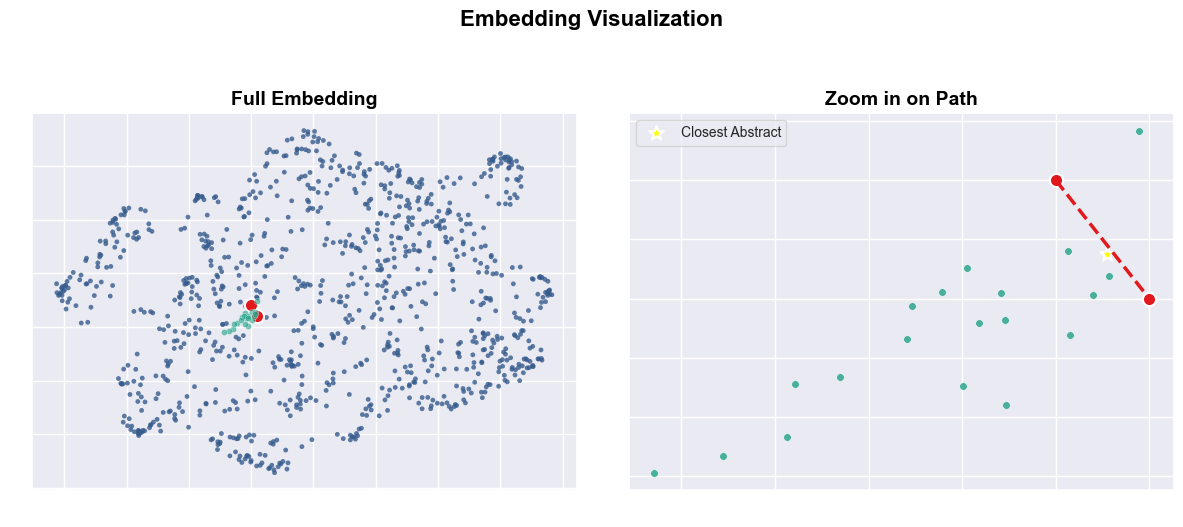

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set seaborn style with gray background
sns.set_theme(style="darkgrid")  # Dark gray background with grid
plt.figure(figsize=(12, 5))

# Create a custom color palette - brighter colors work better on dark backgrounds
palette = sns.color_palette("viridis")
accent_color = sns.color_palette("YlOrRd", 3)[2]  # Bright red/orange for highlighted points

# First subplot - Full embedding
plt.subplot(121)
scatter_kws = {"alpha": 0.8, "s": 12, "linewidth": 0, "edgecolor": "none"}

# Main scatter plot with improved aesthetics
sns.scatterplot(
    x=transform.embedding_[:, 0], 
    y=transform.embedding_[:, 1], 
    color=palette[1],
    **scatter_kws
)

# Red points
sns.scatterplot(
    x=[p0[0][0], p1[0][0]], 
    y=[p0[0][1], p1[0][1]],
    color=accent_color, 
    s=90,
    marker='o',
    edgecolor='white',
    linewidth=1.5
)

# Blue points with better opacity
sns.scatterplot(
    x=newpts[:, 0], 
    y=newpts[:, 1], 
    color=palette[3],
    s=20, 
    alpha=0.6
)

plt.title("Full Embedding", fontsize=14, fontweight='bold', color='black')
plt.tight_layout()

# Second subplot - Zoom in on path
plt.subplot(122)

# Red points 
sns.scatterplot(
    x=[p0[0][0], p1[0][0]], 
    y=[p0[0][1], p1[0][1]],
    color=accent_color, 
    s=90,
    marker='o',
    edgecolor='white',
    linewidth=1.5
)

# Blue points
sns.scatterplot(
    x=newpts[:, 0], 
    y=newpts[:, 1], 
    color=palette[3],
    s=30, 
    alpha=0.8
)

# Find closest point
closest_index = closest_point_index_on_segment(p0[0, 0], p0[0, 1], p1[0, 0], p1[0, 1], newpts)

# Highlight closest point
sns.scatterplot(
    x=[newpts[closest_index, 0]], 
    y=[newpts[closest_index, 1]], 
    color='yellow',  # Yellow stands out well on dark backgrounds
    s=120, 
    marker='*',
    label="Closest Abstract",
    edgecolor='white',
    linewidth=1.5
)

# Red line connecting p0 and p1
redline = np.vstack([p0, p1])
plt.plot(redline[:, 0], redline[:, 1], linestyle='--', c=accent_color, linewidth=2.5)

plt.title("Zoom in on Path", fontsize=14, fontweight='bold', color='black')
plt.legend(frameon=True, framealpha=0.7, fontsize=10)

# Add some finishing touches - light colored text for dark background
plt.suptitle("Embedding Visualization", fontsize=16, y=1.05, fontweight='bold', color='black')
plt.tight_layout()

# Optional: Set tick colors to white for better visibility
for ax in plt.gcf().get_axes():
    ax.tick_params(colors='white')
    for spine in ax.spines.values():
        spine.set_edgecolor('white')

# Show the plot
plt.show()

In [34]:
print("Closest Generated Abstract:\n", newabs[closest_index])
 

Closest Generated Abstract:
 We investigate the potential of deep learning models to enhance the accuracy of noise spectroscopy in quantum systems, particularly in the presence of environmental interactions. By drawing an analogy between the dynamics of interacting particles and the learning process in neural networks, we explore whether a depth-two neural network can accurately reconstruct the power spectral density of noise induced by environmental impurities. Assuming a linear output node, we show that the convergence of gradient descent in learning the target network is analogous to the equilibrium configurations of charged particles in electrodynamics. This equivalence provides a framework to analyze how neural networks can be trained to match the spectral content of noise, leveraging the dynamics of hidden nodes. We demonstrate that through iterative learning, a neural network can effectively reconstruct the noise spectrum with high accuracy, using fewer dynamical decoupling sequ

In [35]:
print(f"Proposed New Topic\n{newabs[closest_index]} \n\nExisting topic 1:\n{ab_0}\n\nExisting topic:2\n{ab_1}")

Proposed New Topic
We investigate the potential of deep learning models to enhance the accuracy of noise spectroscopy in quantum systems, particularly in the presence of environmental interactions. By drawing an analogy between the dynamics of interacting particles and the learning process in neural networks, we explore whether a depth-two neural network can accurately reconstruct the power spectral density of noise induced by environmental impurities. Assuming a linear output node, we show that the convergence of gradient descent in learning the target network is analogous to the equilibrium configurations of charged particles in electrodynamics. This equivalence provides a framework to analyze how neural networks can be trained to match the spectral content of noise, leveraging the dynamics of hidden nodes. We demonstrate that through iterative learning, a neural network can effectively reconstruct the noise spectrum with high accuracy, using fewer dynamical decoupling sequences comp

In [23]:
prompt = f"""Given the following abstract from a journal publication, generate a hypothesis that would lead to the results posted 
in this abstract.

### Journal Abstract
{newabs[closest_index]}
"""
rc =client.chat.completions.create(model="asdf", messages=[{"role":"user", "content":prompt}])

print(rc.choices[0].message.content)

### Hypothesis
The hypothesis that would lead to the results posted in the abstract could be:

"Training a depth-two neural network with a linear output node using gradient descent can effectively reconstruct the power spectral density of environmental noise in quantum systems, achieving high accuracy with fewer dynamical decoupling sequences compared to traditional methods."

This hypothesis is based on the idea that the neural network, by leveraging the dynamics of its hidden nodes and through iterative learning, can converge to a model that accurately represents the noise spectrum, analogous to the equilibrium configurations of charged particles in electrodynamics.


In [24]:
prompt = f"""Given the following abstract from a journal publication, you are inspired to research this same topic.   What is 
your thought process and what would you do next?

### Journal Abstract
{newabs[closest_index]}
"""
rc =client.chat.completions.create(model="asdf", messages=[{"role":"user", "content":prompt}])
print(rc.choices[0].message.content)

The abstract you've provided is quite intriguing as it bridges the gap between quantum physics and machine learning. The research suggests that deep learning models can enhance noise spectroscopy in quantum systems and that the dynamics of neural networks can be understood through an analogy with electrodynamics. Given this, here's a thought process and a plan of action for conducting similar research:

### Thought Process

1. **Understanding the Problem**: The core problem here is improving the accuracy of noise spectroscopy in quantum systems, especially when they interact with their environment. Noise spectroscopy is crucial for understanding and mitigating errors in quantum devices.

2. **Key Concepts and Theoretical Background**:
    - **Deep Learning Models**: Specifically, the use of depth-two neural networks for this task.
    - **Power Spectral Density (PSD) Reconstruction**: The target is to accurately reconstruct the PSD of the noise.
    - **Gradient Descent and Neural Netw